In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, pickle

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
np.set_printoptions(linewidth=120, precision=5, suppress=True)

import tensorflow as tf
tf.config.optimizer.set_experimental_options({
    'layout_optimizer': False,
})

from keras import backend as K
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Lambda, BatchNormalization, Activation
from keras.layers import multiply
from keras.models import Model
from keras import initializers
from tensorflow.keras.optimizers import Adam

from layers import conv_init_linear, conv_init_relu, conv_init_relu2
from layers import depthwiseconv_init_linear, depthwiseconv_init_relu
from layers import normal_init, uniform_init

all_results = {}

### Activation

In [2]:
def calc_statistics(conv_block, initializers, activations, plot=False):
    input_shape = (128,64,64,40)
    x = np.random.randn(*input_shape)

    print('%-33s %7s %7s %7s %7s' % ('', 'mean', 'std', 'var', 'meanabs'))
    print('%-33s %7.3f %7.3f %7.3f %7.2f' % ('input', np.mean(x), np.std(x), np.var(x), np.mean(np.abs(x))))

    for acti in activations:
        print(acti)
        for init in initializers:
            
            x1 = x_in = Input(input_shape[1:]) 
            x1 = conv_block(x1, init, acti)
            if type(x1) is list:
                x1 = multiply(x1)
            model = Model(x_in, x1)

            y = model.predict(x, verbose=0)
            
            init_name = init if type(init) == str else init.__name__
            print(' %-32s %7.3f %7.3f %7.3f %7.2f' % (init_name, np.mean(y), np.std(y), np.var(y), np.mean(np.abs(y))))

            if plot:
                plt.figure(figsize=(8,2))
                plt.axvline(np.mean(x), alpha=0.5, linestyle='--', color='tab:blue')
                plt.axvline(np.mean(y), alpha=0.5, linestyle='--', color='tab:orange')
                sns.histplot(x[0,:,:,0:4].flatten(), bins=24, kde=True, linewidth=0)
                sns.histplot(y[0,:,:,0:4].flatten(), bins=24, kde=True, linewidth=0)
                plt.title('%s, %s' % (acti, init_name)); plt.grid()
                plt.show()

In [42]:
# Conv2D

initializers = [
    'he_uniform',
    'he_normal',
    'glorot_uniform',
    'glorot_normal',
    conv_init_linear,
    conv_init_relu,
    #conv_init_relu2,
    normal_init,
    uniform_init,
]

activations = ['linear', 'relu']

def conv_block(x, initializer, activation):
    x = Conv2D(16,3, use_bias=False, kernel_initializer=initializer, activation=activation)(x)
    return x

calc_statistics(conv_block, initializers, activations, plot=False)

                                     mean     std     var meanabs
input                              -0.000   1.000   1.000    0.80
linear
 he_uniform                        -0.001   1.416   2.006    1.13
 he_normal                         -0.001   1.398   1.954    1.11
 glorot_uniform                     0.001   1.191   1.418    0.95
 glorot_normal                      0.000   1.194   1.426    0.95
 conv_init_linear                   0.000   1.003   1.006    0.80
 conv_init_relu                    -0.000   1.407   1.980    1.12
 normal_init                       -0.006  18.996 360.854   15.15
 uniform_init                      -0.012  18.983 360.349   15.14
relu
 he_uniform                         0.564   0.826   0.682    0.56
 he_normal                          0.556   0.815   0.664    0.56
 glorot_uniform                     0.479   0.702   0.492    0.48
 glorot_normal                      0.477   0.699   0.488    0.48
 conv_init_linear                   0.404   0.591   0.350    0.4

In [31]:
# SparseConv2D

initializers = [
    #'he_uniform',
    #'he_normal',
    #'glorot_uniform',
    #'glorot_normal',
    conv_init_linear,
    conv_init_relu,
    #conv_init_relu2,
    normal_init,
    uniform_init,
]

activations = ['linear', 'relu']

def conv_block(x, initializer, activation):
    from layers import SparseConv2D
    #xm = [x, Lambda(lambda x: tf.ones_like(x)[:,:,:,:1])(x)]
    xm = x
    xm = SparseConv2D(6, 3, kernel_initializer=initializer, activation=activation)(xm)
    return xm

calc_statistics(conv_block, initializers, activations, plot=False)

                                     mean     std     var meanabs
input                              -0.000   1.000   1.000    0.80
linear
 conv_init_linear                   0.001   0.989   0.979    0.79
 conv_init_relu                     0.000   1.402   1.967    1.12
 normal_init                        0.020  19.269 371.282   15.36
 uniform_init                       0.011  18.942 358.795   15.11
relu
 conv_init_linear                   0.398   0.582   0.339    0.40
 conv_init_relu                     0.558   0.817   0.667    0.56
 normal_init                        7.341  10.766 115.914    7.34
 uniform_init                       7.659  11.205 125.542    7.66


In [43]:
# PartialConv2D

initializers = [
    #'he_uniform',
    #'he_normal',
    #'glorot_uniform',
    #'glorot_normal',
    conv_init_linear,
    conv_init_relu,
    #conv_init_relu2,
    normal_init,
    uniform_init,
]

activations = ['linear', 'relu']

def conv_block(x, initializer, activation):
    from layers import PartialConv2D
    #xm = [x, Lambda(lambda x: tf.ones_like(x)[:,:,:,:1])(x)]
    xm = x
    xm = PartialConv2D(6, 3, kernel_initializer=initializer, activation=activation)(xm)
    return xm

calc_statistics(conv_block, initializers, activations, plot=False)

                                     mean     std     var meanabs
input                               0.000   1.000   1.001    0.80
linear
 conv_init_linear                   0.000   0.998   0.997    0.80
 conv_init_relu                     0.001   1.442   2.079    1.15
 normal_init                       -0.009  19.104 364.975   15.24
 uniform_init                       0.002  18.790 353.050   14.99
relu
 conv_init_linear                   0.399   0.584   0.342    0.40
 conv_init_relu                     0.559   0.818   0.669    0.56
 normal_init                        7.577  11.084 122.863    7.58
 uniform_init                       7.583  11.104 123.304    7.58


In [34]:
# DepthwiseConv2D

initializers = [
    #'he_uniform',
    #'he_normal',
    #'glorot_uniform',
    #'glorot_normal',
    conv_init_linear,
    conv_init_relu,
    #conv_init_relu2,
    depthwiseconv_init_linear,
    depthwiseconv_init_relu,
    #normal_init,
    #uniform_init,
]

activations = ['linear', 'relu']

def conv_block(x, initializer, activation):
    from layers import DepthwiseConv2D
    x = DepthwiseConv2D(4, 3, kernel_initializer=initializer, activation=activation, use_bias=False)(x)
    return x

calc_statistics(conv_block, initializers, activations, plot=False)

                                     mean     std     var meanabs
input                              -0.000   1.000   1.000    0.80
linear
 conv_init_linear                   0.000   0.156   0.024    0.12
 conv_init_relu                     0.000   0.220   0.048    0.17
 depthwiseconv_init_linear         -0.000   1.002   1.004    0.78
 depthwiseconv_init_relu           -0.000   1.403   1.970    1.09
relu
 conv_init_linear                   0.061   0.092   0.009    0.06
 conv_init_relu                     0.087   0.133   0.018    0.09
 depthwiseconv_init_linear          0.393   0.599   0.359    0.39
 depthwiseconv_init_relu            0.553   0.844   0.712    0.55


In [35]:
# keras DepthwiseConv2D

initializers = [
    #'he_uniform',
    #'he_normal',
    #'glorot_uniform',
    #'glorot_normal',
    conv_init_linear,
    conv_init_relu,
    #conv_init_relu2,
    depthwiseconv_init_linear,
    depthwiseconv_init_relu,
    #normal_init,
    #uniform_init,
]

activations = ['linear', 'relu']

def conv_block(x, initializer, activation):
    from tensorflow.keras.layers import DepthwiseConv2D
    x = DepthwiseConv2D(3, depth_multiplier=4, kernel_initializer=initializer, activation=activation, use_bias=False)(x)
    return x

calc_statistics(conv_block, initializers, activations, plot=False)

                                     mean     std     var meanabs
input                              -0.000   1.000   1.000    0.80
linear
 conv_init_linear                  -0.000   0.215   0.046    0.17
 conv_init_relu                     0.000   0.212   0.045    0.17
 depthwiseconv_init_linear          0.000   0.211   0.044    0.17
 depthwiseconv_init_relu            0.000   0.215   0.046    0.17
relu
 conv_init_linear                   0.084   0.124   0.015    0.08
 conv_init_relu                     0.083   0.123   0.015    0.08
 depthwiseconv_init_linear          0.084   0.125   0.016    0.08
 depthwiseconv_init_relu            0.083   0.123   0.015    0.08


### Convergence

In [44]:
from training import cross_entropy_loss

values = np.array([[1,0,0],[0,1,0],[0,0,1],[1,1,0],[1,0,1],[0,1,1]])
num_classes = len(values)

num_samples = 100
num_epochs = 20
batch_size = 256

n = 10

def generator(batch_size):
    while True:
        x, y = [], []
        for i in range(batch_size):
            idx = np.random.randint(num_classes)
            one_hot = np.zeros(num_classes)
            one_hot[idx] = 1
            value = (values[idx]*2-1) * np.abs(np.random.random(3))
            x.append( np.tile(value, (32,32,1)) )
            y.append( one_hot )
        yield np.asarray(x, dtype='float32'), np.asarray(y, dtype='float32')


def evaluate_initializer(model_name, conv_block, initializers, n=n, learning_rate=1e-3):
    print('%i epochs, %i samples, %i runs ' % (num_epochs, num_samples))
    results = {}

    for initializer in initializers:
        loss = []

        initializer_name = initializer if type(initializer) == str else initializer.__name__
        name = model_name + '_' + initializer_name
        print(name)
        
        for j in range(n):
            optimizer = Adam(learning_rate=learning_rate)
            
            x = x_in = Input((32,32,3))
            for i in range(4):
                x = conv_block(x, initializer)
            if type(x) is list:
                x = x[0]
            x = GlobalAveragePooling2D()(x)
            x = Dense(6, kernel_initializer='he_normal')(x)
            x = Activation('sigmoid')(x)
            model = Model(x_in, x, name=model_name)
        
            model.compile(optimizer=optimizer, loss=cross_entropy_loss)
            model.fit(generator(batch_size), epochs=num_epochs, steps_per_epoch=num_samples, verbose=0)

            loss.append(model.history.history['loss'])

        results[name] = np.array(loss)
        
    return results


def plot_with_std(x, y, label):
    mean, std = np.mean(y, axis=0), np.std(y, axis=0)
    plt.plot(x, mean, label=label)
    plt.fill_between(x, mean-std, mean+std, alpha=0.25)

def plot_training(results):
    
    plt.figure(figsize=(16,8))
    epochs = np.arange(1,num_epochs+1)
    for k, v in results.items():
        plot_with_std(epochs, v, k)
    plt.legend(); plt.grid(); plt.xlim(epochs[0],epochs[-1]); plt.ylim(0,None)
    plt.show()
    
    x = list(reversed(results.keys()))
    y = [np.mean(results[k][:,-3:]) for k in x]
    plt.figure(figsize=(8, 0.2+0.2*len(x)))
    plt.barh(x,y)
    plt.title('final loss')
    plt.show()


In [ ]:
# Conv2D

initializers = [
    #'he_uniform',
    #'he_normal',
    #'glorot_uniform',
    #'glorot_normal',
    conv_init_linear,
    conv_init_relu,
    conv_init_relu2,
]

def conv_block(x, initializer):
    from layers import Conv2D
    return Conv2D(6, 3, kernel_initializer=initializer, activation='relu')(x)

results = evaluate_initializer('conv', conv_block, initializers)
all_results.update(results)

In [ ]:
# SparseConv2D

initializers = [
    #'he_uniform',
    #'he_normal',
    #'glorot_uniform',
    #'glorot_normal',
    conv_init_linear,
    conv_init_relu,
    #conv_init_relu2,
]

def conv_block(x, initializer):
    from layers import SparseConv2D
    if type(x) is list:
        xm = x
    else:
        xm = [x, Lambda(lambda x: tf.ones_like(x)[:,:,:,:1])(x)]
    xm = SparseConv2D(6, 3, kernel_initializer=initializer, activation='relu')(xm)
    return xm

results = evaluate_initializer('sconv', conv_block, initializers)
all_results.update(results)

In [ ]:
# PartialConv2D

initializers = [
    #'he_uniform',
    #'he_normal',
    #'glorot_uniform',
    #'glorot_normal',
    conv_init_linear,
    conv_init_relu,
    #conv_init_relu2,
]

def conv_block(x, initializer):
    from layers import PartialConv2D
    if type(x) is list:
        xm = x
    else:
        xm = [x, Lambda(lambda x: tf.ones_like(x)[:,:,:,:1])(x)]
    xm = PartialConv2D(6, 3, kernel_initializer=initializer, activation='relu')(xm)
    return xm

results = evaluate_initializer('pconv', conv_block, initializers)
all_results.update(results)

In [ ]:
# DepthwiseConv2D

initializers = [
    #'he_uniform',
    #'he_normal',
    #'glorot_uniform',
    #'glorot_normal',
    conv_init_linear,
    conv_init_relu,
    #conv_init_relu2,
    depthwiseconv_init_linear,
    depthwiseconv_init_relu,
]

def conv_block(x, initializer):
    from layers import DepthwiseConv2D
    x = DepthwiseConv2D(2, 3, kernel_initializer=initializer, use_bias=False)(x)
    x = Conv2D(6, 1, kernel_initializer=conv_init_relu)(x)
    x = Activation('relu')(x)
    return x

results = evaluate_initializer('dconv', conv_block, initializers)
all_results.update(results)

In [ ]:
# Conv2D equalized

initializers = [
    #conv_init_relu,
    #normal_init,
    uniform_init,
]

def conv_block(x, initializer):
    from layers import Conv2D
    x = Conv2D(6, 3, kernel_initializer=initializer, activation='relu', equalize=True)(x)
    return x

results = evaluate_initializer('econv', conv_block, initializers)
all_results.update(results)

In [ ]:
# Conv2D equalized larger learning rate

initializers = [
    #conv_init_relu,
    #normal_init,
    uniform_init,
]

def conv_block(x, initializer):
    from layers import Conv2D
    x = Conv2D(6, 3, kernel_initializer=initializer, activation='relu', equalize=True)(x)
    return x

results = evaluate_initializer('econv_lr', conv_block, initializers, learning_rate=1e-2)
all_results.update(results)

In [ ]:
# Conv2D larger learning rate

initializers = [
    #conv_init_relu,
    #normal_init,
    uniform_init,
]

def conv_block(x, initializer):
    from layers import Conv2D
    x = Conv2D(6, 3, kernel_initializer=initializer, activation='relu', equalize=False)(x)
    return x

results = evaluate_initializer('conv_lr', conv_block, initializers, learning_rate=1e-2)
all_results.update(results)

In [ ]:
# Conv2D + BN

initializers = [
    conv_init_relu,
    normal_init,
]

def conv_block(x, initializer):
    from layers import Conv2D
    x = Conv2D(6, 3, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

results = evaluate_initializer('conv_bn', conv_block, initializers)
all_results.update(results)

In [ ]:
# Conv2D + WN

initializers = [
    conv_init_relu,
    normal_init,
]

def conv_block(x, initializer):
    from layers import Conv2D
    x = Conv2D(6, 3, kernel_initializer=initializer, activation='relu', weightnorm=True)(x)
    return x

results = evaluate_initializer('conv_wn', conv_block, initializers)
all_results.update(results)

In [ ]:
for k in all_results.keys():
    print(k)

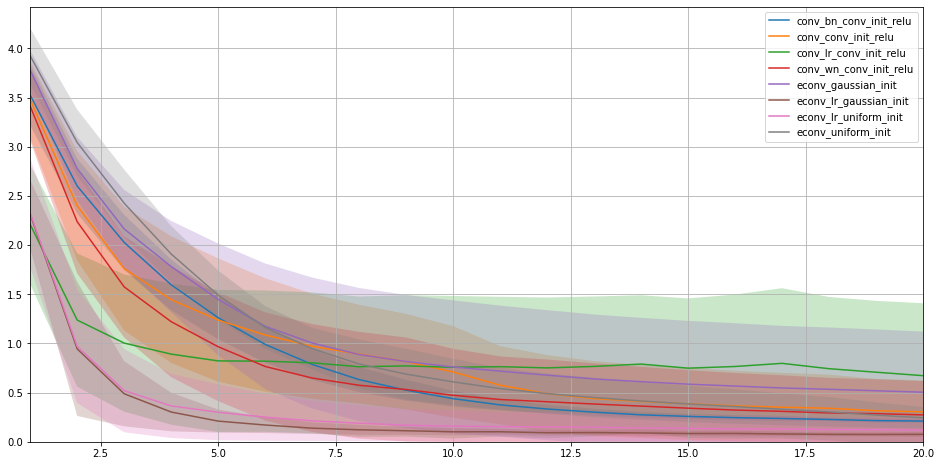

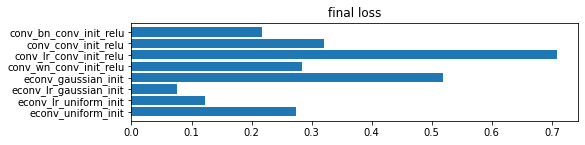

In [46]:
#keys = [k for k in all_results.keys() if k.startswith('conv_')]
#keys = [k for k in all_results.keys() if k.find('_lr_') != -1]
keys = ['conv_conv_init_relu', 'conv_lr_conv_init_relu', 
        'conv_bn_conv_init_relu', 'conv_wn_conv_init_relu', 
        'econv_gaussian_init', 'econv_lr_gaussian_init',
        'econv_uniform_init', 'econv_lr_uniform_init']

results = {k:all_results[k] for k in sorted(keys)}
plot_training(results)

In [40]:
if 0:
    with open('initialization_results.pkl', 'wb') as f:
        pickle.dump(all_results, f)
else:
    with open('initialization_results.pkl', 'rb') as f:
        all_results = pickle.load(f)